# Trabajo Práctico N6. Color

In [79]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [80]:
#Funciones auxiliares

def myplotimg (img,vmin=0,vmax=255,title=None):
  plt.imshow(img,cmap='gray', vmin=vmin, vmax=vmax)
  if title != None:
    plt.title(title)
  plt.axis("off")
  plt.show()
  return

def show_side_by_side(imgs, subtitles = None, title = None, vmin=0, vmax=255, **kwargs):
    fig, axes = plt.subplots(1, len(imgs), **kwargs)
    if len(imgs) == 1:
        axes = [axes]
    if title is not None:
        fig.suptitle(title, y=0.8)
    if subtitles is None:
        subtitles = [None for _ in imgs]
    for ax, img, subtitle in zip(axes, imgs, subtitles):
        if subtitle is not None:
            ax.set_title(subtitle)
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), vmin=vmin, vmax=vmax)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

## 1)

In [81]:
def segment_ranges(img, ranges):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    final_mask = np.zeros(img.shape[:-1], dtype=np.uint8)

    for (start, end) in ranges:
        mask = cv2.inRange(hsv, start, end)
        final_mask = cv2.bitwise_or(final_mask, mask)

    return cv2.bitwise_and(img, img, mask=final_mask)

### a)

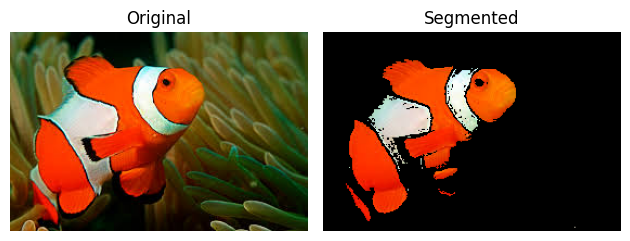

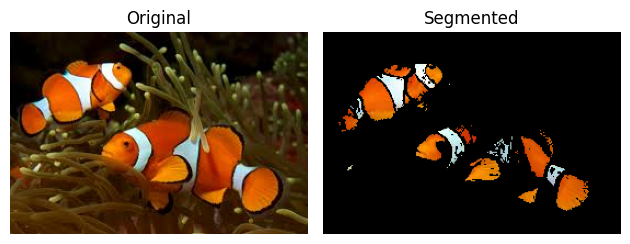

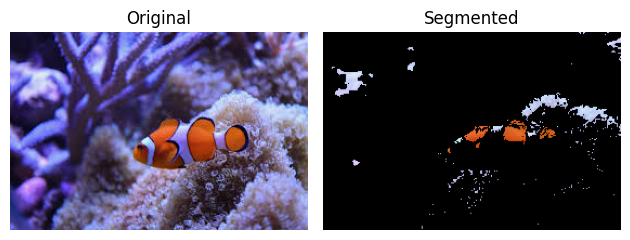

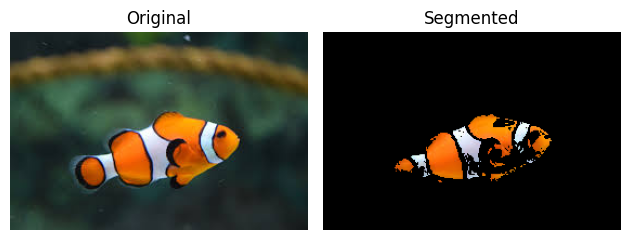

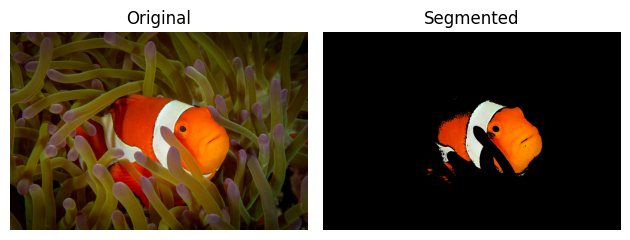

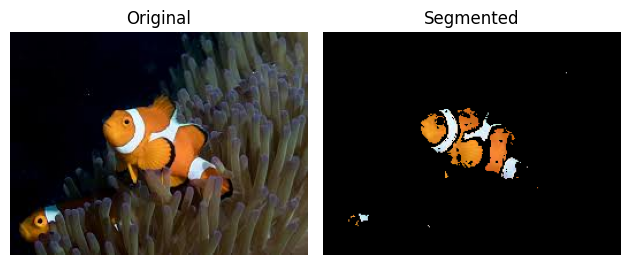

In [82]:
nemo_images = [cv2.imread(f"finding_nemo/images/nemo{n}.jpg") for n in range(6)]

def segment_nemo(img):
    light_orange = (18, 255, 255)
    dark_orange = (1, 190, 200)

    light_white = (145, 60, 255)
    dark_white = (0, 0, 200)

    return segment_ranges(img, ((dark_orange, light_orange), (dark_white, light_white)))

for nemo in nemo_images:
    show_side_by_side([nemo, segment_nemo(nemo)], ["Original", "Segmented"])

### b)

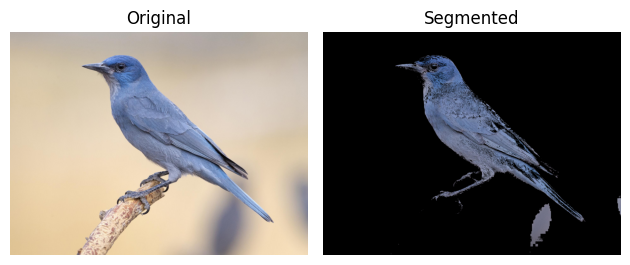

In [83]:
bird = cv2.imread("bird.jpg")

def segment_bird(img):
    dark = (107, 30, 65)
    light = (151, 161, 200)

    return segment_ranges(img, ((dark, light),))

show_side_by_side([bird, segment_bird(bird)], ["Original", "Segmented"])